In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.plotly as py
import seaborn as sns 
import plotly.graph_objs as go

In [423]:
!pip install xlrd

In [0]:
import xlrd



In [0]:
#df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
#pdf = df
df= pd.read_excel("https://github.com/PriyadharshanSaba/OnlineRetailSales-RMFmodel/raw/master/Dataset/Online%20Retail.xlsx")


In [426]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [427]:
#DATA WRANGLING

#dropping NaN data rows
df=df.dropna()

#dropping description column
df=df.drop(columns=['Description'])
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
df['Amount'] = df.UnitPrice * df.Quantity
#removing unit price
df=df.drop(columns=['UnitPrice'])

df['date'] = [d.date() for d in df['InvoiceDate']]
df['time'] = [d.time() for d in df['InvoiceDate']]
#print(df.head())


In [429]:
#CLEANING CUSTOMERS

#dropping NaN values in CustomerID
df = df[np.isfinite(df['CustomerID'])]      #df.loc[df['InvoiceNo']==573174]  reference for NaN value

#removing customers with less than 1Re of transaction
df=df[(df['Amount'] >=1)]
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,CustomerID,Country,Amount,date,time
0,536365,85123A,6,2010-12-01 08:26:00,17850.0,United Kingdom,15.30,2010-12-01,08:26:00
1,536365,71053,6,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
2,536365,84406B,8,2010-12-01 08:26:00,17850.0,United Kingdom,22.00,2010-12-01,08:26:00
3,536365,84029G,6,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00
4,536365,84029E,6,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00


In [430]:
#grouping by countries and adding purchasing percentage on basis of quantity
group_country = df.groupby(['Country'],as_index=False).sum()
group_country = group_country.drop(columns=['CustomerID'])
group_country.sort_values('Quantity',ascending=False,inplace=True)

total_purchased = group_country['Quantity'].sum()
group_country['Buy_perc']=(group_country['Quantity']/total_purchased)*100
group_country.head()


,Country,Quantity,Amount,Buy_perc
35,United Kingdom,4239362,7.299319e+06,82.314544
23,Netherlands,200324,2.854209e+05,3.889637
10,EIRE,140275,2.655459e+05,2.723682
14,Germany,119249,2.288581e+05,2.315426
13,France,111414,2.089972e+05,2.163295


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



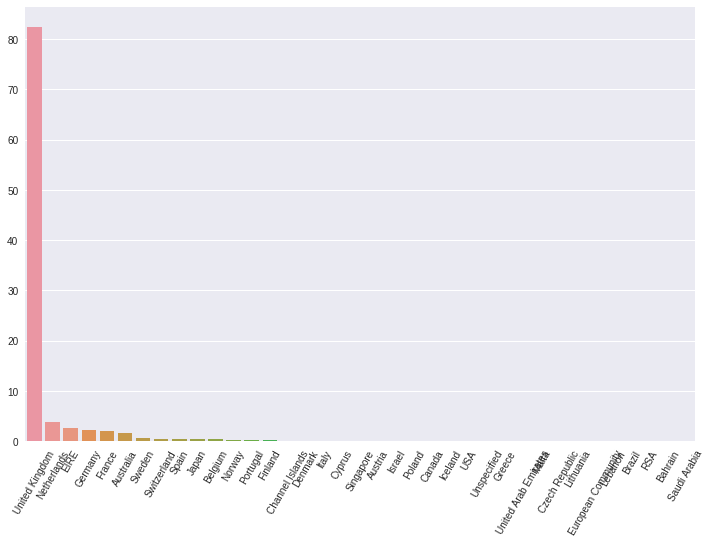

In [431]:
#Buy_Perc plotting

country=list(group_country['Country'])
Cust_id=list(group_country['Buy_perc'])
plt.figure(figsize=(12,8))
sns.barplot(country, Cust_id, alpha=1)
plt.xticks(rotation='60')
plt.show()


In [0]:
#analysing country with highest purchasing 
x=group_country.where(group_country['Buy_perc']==group_country['Buy_perc'].max())
x=x['Country'].dropna().get_values().tolist()[0]

dfcur = df.where(df.Country == x)
dfcur=dfcur.dropna()

In [433]:
#first time buyers
x=dfcur.groupby('CustomerID',).count()
no_customers= x['InvoiceNo'].count()
no_first_timers=x.where(x['InvoiceNo']==1).dropna().count()['InvoiceNo']
print('Percentage of new customers purchasing for the first time',(no_first_timers*100/no_customers))



Percentage of new customers purchasing for the first time 1.7857142857142858


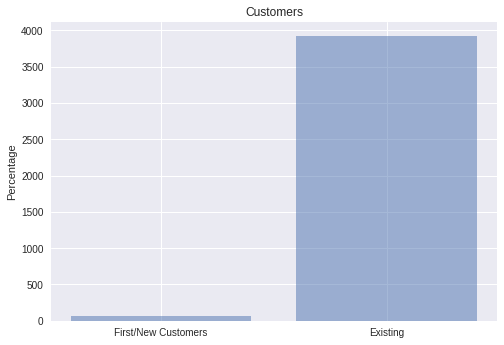

In [434]:
objects = ('First/New Customers', 'Existing')
y_pos = np.arange(len(objects))
perc = [no_first_timers,no_customers]
plt.bar(y_pos, perc, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage')
plt.title('Customers')
 
plt.show()

In [0]:
#Converting to date to shortened string formate %y(2)%m
dfcur['dateS']=dfcur['date'].apply(lambda x: x.strftime('%y%m'))
#print('Far date: ',dfcur['dateS'].min(),"\tRecent: ",dfcur['dateS'].max())

In [0]:
#RMF MODEL

#---- Recency Analysis------
def recency(row):
  if int(row['dateS']) > 1109:
    val = 5
  elif int(row['dateS']) <= 1109 and int(row['dateS']) > 1106:
    val = 4
  elif int(row['dateS']) <= 1106 and int(row['dateS']) > 1103:
    val = 3
  elif int(row['dateS']) <= 1103 and int(row['dateS']) > 1101:
    val = 2
  else:
    val = 1
  return val
  
dfcur['Recency_val'] = dfcur.apply(recency, axis=1)

In [437]:
dfcur.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,CustomerID,Country,Amount,date,time,dateS,Recency_val
0,536365,85123A,6.0,2010-12-01 08:26:00,17850.0,United Kingdom,15.30,2010-12-01,08:26:00,1012,1
1,536365,71053,6.0,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,1012,1
2,536365,84406B,8.0,2010-12-01 08:26:00,17850.0,United Kingdom,22.00,2010-12-01,08:26:00,1012,1
3,536365,84029G,6.0,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,1012,1
4,536365,84029E,6.0,2010-12-01 08:26:00,17850.0,United Kingdom,20.34,2010-12-01,08:26:00,1012,1


In [438]:
#table with just recency values
rec_df = dfcur
rec_df = rec_df.drop(columns=['Quantity','InvoiceNo','StockCode','InvoiceDate','Country','Amount','date','time','dateS'])
recencyTable = rec_df.drop_duplicates( keep=False)
rec_df.head()

,CustomerID,Recency_val
0,17850.0,1
1,17850.0,1
2,17850.0,1
3,17850.0,1
4,17850.0,1


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



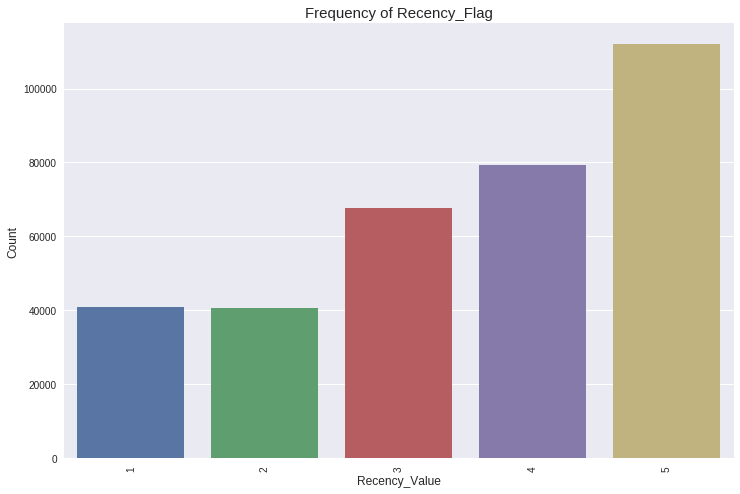

In [439]:
plt.figure(figsize=(12,8))
sns.countplot(x="Recency_val", data=rec_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Recency_Value', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Recency_Flag", fontsize=15)
plt.show()

In [440]:
print("\tRecency Analysis\n",rec_df.groupby('Recency_val',as_index=False).count())




	Recency Analysis
    Recency_val  CustomerID
0            1       40931
1            2       40635
2            3       67785
3            4       79400
4            5      112059


In [441]:
#------Frequency Analysis-------

freq_df = dfcur[['Country','InvoiceNo','CustomerID']].drop_duplicates()
freq_count = freq_df.groupby(['Country','CustomerID'],as_index=False)[['InvoiceNo']].count()
freq_count.head()

,Country,CustomerID,InvoiceNo
0,United Kingdom,12346.0,1
1,United Kingdom,12747.0,11
2,United Kingdom,12748.0,207
3,United Kingdom,12749.0,5
4,United Kingdom,12820.0,4


In [442]:
unique_invoice=freq_df[['InvoiceNo']].drop_duplicates()
unique_invoice.head()

,InvoiceNo
0,536365
7,536366
9,536367
21,536368
25,536369


In [443]:
#Dividing the dataframe into 5 bands
unique_invoice['fband']=pd.qcut(unique_invoice['InvoiceNo'],5)
unique_invoice.head()
freqBandTable = unique_invoice[['fband']].drop_duplicates().reset_index()
freqBandTable

,index,fband
0,0,"(536364.999, 546000.2]"
1,113904,"(546000.2, 555005.8]"
2,207810,"(555005.8, 564094.4]"
3,309586,"(564094.4, 573101.6]"
4,422644,"(573101.6, 581586.0]"


In [444]:
def frequ(row):
  if row['InvoiceNo'] <= 13:
    val = 1
  elif row['InvoiceNo'] > 13 and row['InvoiceNo']<=24:
    val =2
  elif row['InvoiceNo']>24 and row['InvoiceNo']<=35:
    val = 3
  elif row['InvoiceNo']>35 and row['InvoiceNo']<=60:
    val = 4
  else:
    val = 5
  return val

freq_count['freq_val'] = freq_count.apply(frequ,axis=1)
freq_count.head()

,Country,CustomerID,InvoiceNo,freq_val
0,United Kingdom,12346.0,1,1
1,United Kingdom,12747.0,11,1
2,United Kingdom,12748.0,207,5
3,United Kingdom,12749.0,5,1
4,United Kingdom,12820.0,4,1


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



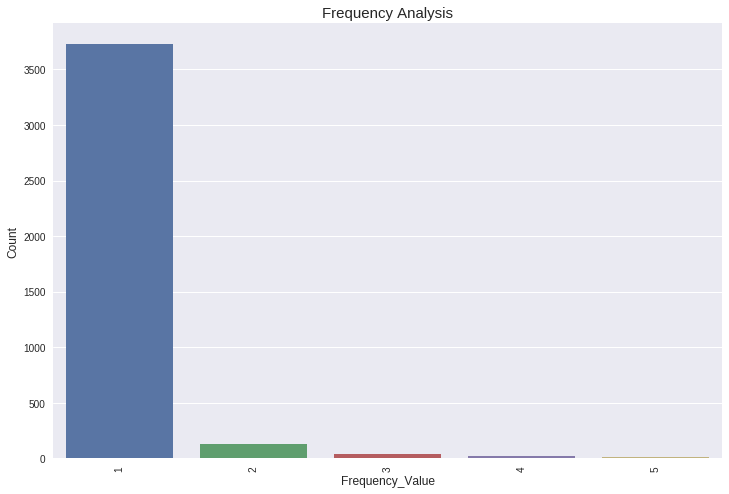

In [445]:
plt.figure(figsize=(12,8))
sns.countplot(x="freq_val", data=freq_count)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Frequency_Value', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency Analysis", fontsize=15)
plt.show()

In [446]:
print("\tFrequency Analysis\n",freq_count.groupby('freq_val',as_index=False).count())




	Frequency Analysis
    freq_val  Country  CustomerID  InvoiceNo
0         1     3729        3729       3729
1         2      127         127        127
2         3       37          37         37
3         4       19          19         19
4         5        8           8          8


In [447]:
#----MonetaryValue Analysis------

#monetary value for each country
monetary_df_countries = df.groupby(['Country','CustomerID'],as_index=False)['Amount'].sum()
monetary_df_countries.head()

,Country,CustomerID,Amount
0,Australia,12386.0,401.90
1,Australia,12388.0,2780.66
2,Australia,12393.0,1582.60
3,Australia,12415.0,124910.63
4,Australia,12422.0,386.20


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



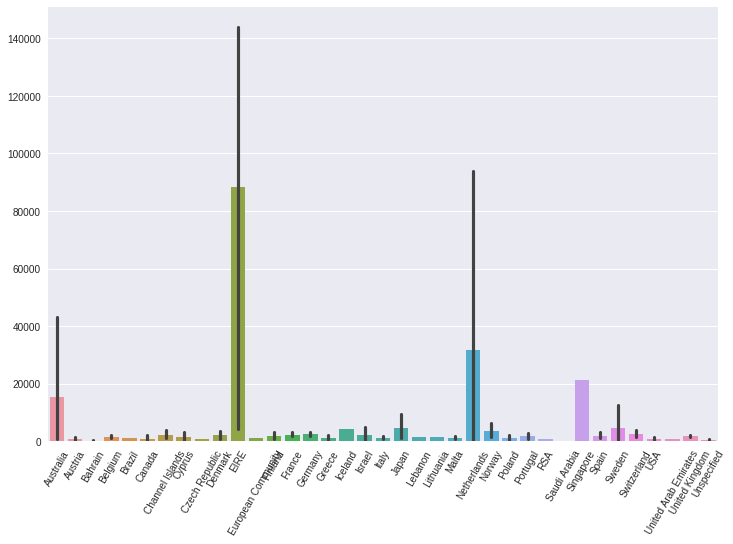

In [448]:
ctry=list(monetary_df_countries['Country'])
amt=list(monetary_df_countries['Amount'])
plt.figure(figsize=(12,8))
sns.barplot(ctry, amt, alpha=1)
plt.xticks(rotation='60')
plt.show()

In [449]:
print("\tMonetary Analysis Countrywise\n",monetary_df_countries.groupby('Country',as_index=False)[['Amount']].sum().sort_values('Amount', ascending=False).reset_index(drop=True).head())

	Monetary Analysis Countrywise
           Country      Amount
0  United Kingdom  7299318.66
1     Netherlands   285420.87
2            EIRE   265545.90
3         Germany   228858.07
4          France   208997.21


In [450]:
#getting monetary band
monprice_df = dfcur[['CustomerID','Amount']].drop_duplicates()
monprice_df = monprice_df.groupby(['CustomerID'],as_index=False)[['Amount']].sum()
monprice_df['monetary'] = pd.qcut(monprice_df['Amount'],5)
monprice_df=monprice_df.sort_values(by=['monetary'])
monetary_band = monprice_df[['monetary']].drop_duplicates().reset_index(drop=True)
monetary_band

,monetary
0,"(3.749, 171.38]"
1,"(171.38, 306.886]"
2,"(306.886, 511.26]"
3,"(511.26, 955.366]"
4,"(955.366, 168472.5]"


In [451]:
x=monetary_band['monetary'].get_values().tolist()
x

[Interval(3.749, 171.38, closed='right'),
 Interval(171.38, 306.886, closed='right'),
 Interval(306.886, 511.26, closed='right'),
 Interval(511.26, 955.366, closed='right'),
 Interval(955.366, 168472.5, closed='right')]

In [452]:
def mon(row):
  if row['Amount'] <= x[0].right:
    val = 1
  elif row['Amount']> x[0].right and row['Amount']<=x[1].right:
    val = 2
  elif row['Amount']> x[1].right and row['Amount']<=x[2].right:
    val = 3
  elif row['Amount']> x[2].right and row['Amount']<=x[3].right:
    val = 4
  else:
    val = 5
  return val

monprice_df['Mont_val'] = monprice_df.apply(mon,axis=1)

monprice_df.head()


,CustomerID,Amount,monetary,Mont_val
1263,14598.0,146.04,"(3.749, 171.38]",1
1420,14821.0,48.80,"(3.749, 171.38]",1
3377,17536.0,25.50,"(3.749, 171.38]",1
3702,17984.0,104.23,"(3.749, 171.38]",1
1421,14823.0,142.05,"(3.749, 171.38]",1


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



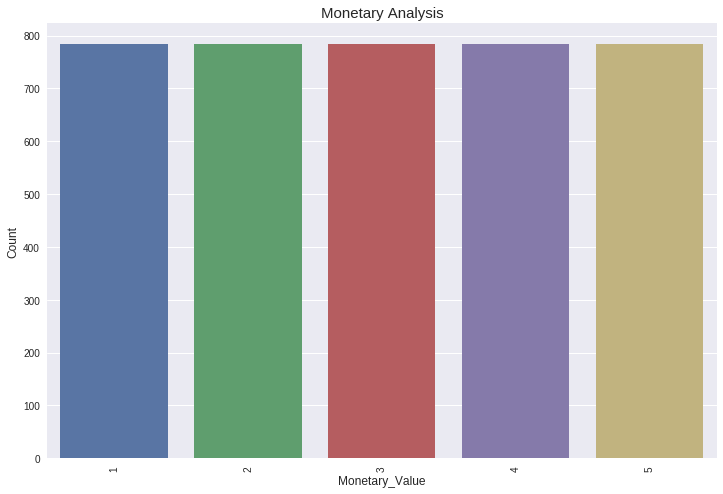

In [453]:
plt.figure(figsize=(12,8))
sns.countplot(x="Mont_val", data=monprice_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Monetary_Value', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Monetary Analysis", fontsize=15)
plt.show()

In [454]:
print("\tMonetary Analysis\n",monprice_df.groupby(['Mont_val'],as_index=False)['monetary'].count())





	Monetary Analysis
    Mont_val  monetary
0         1       784
1         2       784
2         3       784
3         4       784
4         5       784


In [0]:
#fetching the sample with RMF values
uk_df=pd.merge(rec_df,freq_count)
uk_df=pd.merge(uk_df,monprice_df)
sample_df=uk_df
sample_df=sample_df.drop_duplicates().reset_index(drop=True)
sample_df = sample_df.drop(columns=['Country','InvoiceNo','monetary'])

In [456]:
sample_df.head(10)

,CustomerID,Recency_val,freq_val,Amount,Mont_val
0,17850.0,1,3,789.47,4
1,13047.0,1,1,1080.48,5
2,13047.0,2,1,1080.48,5
3,13047.0,3,1,1080.48,5
4,13047.0,4,1,1080.48,5
5,13047.0,5,1,1080.48,5
6,13748.0,1,1,642.95,4
7,13748.0,3,1,642.95,4
8,13748.0,4,1,642.95,4
9,15100.0,1,1,525.60,4


In [0]:
#----CLUSTERING----

#Outliers in Monetary Amount
amountRange = sample_df.as_matrix(columns=['Amount'])


Text(0,0.5,'Frequency')

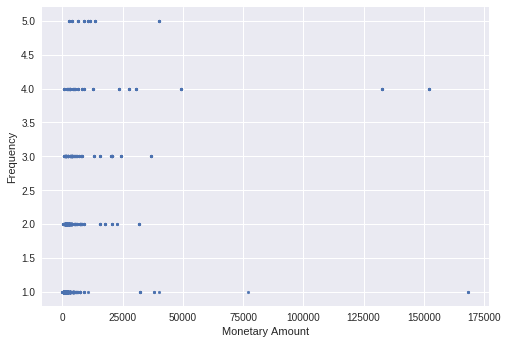

In [506]:
freqRange=sample_df.as_matrix(columns=['freq_val'])
plt.scatter(amountRange.tolist(),freqRange.tolist(),8)
plt.xlabel('Monetary Amount')
plt.ylabel('Frequency')

In [0]:
recRange = sample_df.as_matrix(columns=['freq_val'])

Text(0,0.5,'Recency')

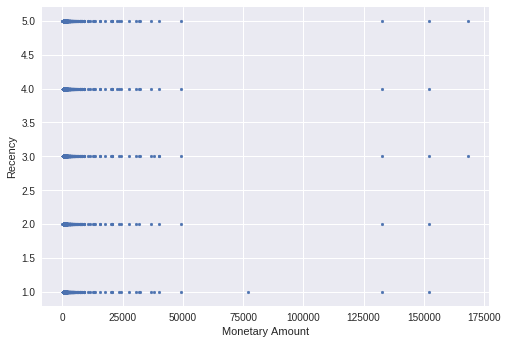

In [508]:
recRange=sample_df.as_matrix(columns=['Recency_val'])
plt.scatter(amountRange.tolist(),recRange.tolist(),8)
plt.xlabel('Monetary Amount')
plt.ylabel('Recency')

In [509]:
#Standard Deviation approach
x = np.array(amountRange)
xmean = np.mean(x,axis=0)
xsd = np.std(x,axis=0)
sample_df.shape
#amountRange = [ i for i in range(0,sample_df.shape[0]) if(sample_df.iloc[i]['Amount'] > xmean-2*xsd)]
#amountRange = [ y for y in amountRange if(y['Amount'] <xmean+2*xsd)]

(8538, 5)

In [512]:
sample_df = sample_df[sample_df['Amount'] >= xmean[0]-2*xsd[0]]
sample_df = sample_df[sample_df['Amount'] <= xmean[0]+2*xsd[0]]
sample_df.head()


,CustomerID,Recency_val,freq_val,Amount,Mont_val
0,17850.0,1,3,789.47,4
1,13047.0,1,1,1080.48,5
2,13047.0,2,1,1080.48,5
3,13047.0,3,1,1080.48,5
4,13047.0,4,1,1080.48,5


Text(0,0.5,'Recency')

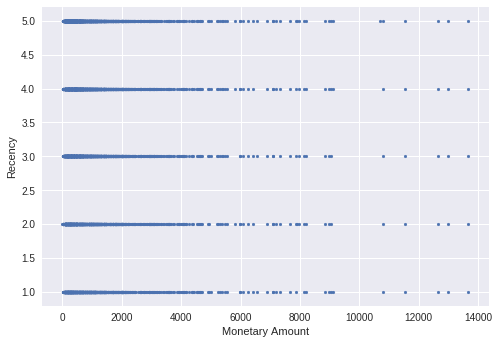

In [513]:
amountRange = sample_df.as_matrix(columns=['Amount'])
recRange=sample_df.as_matrix(columns=['Recency_val'])
plt.scatter(amountRange.tolist(),recRange.tolist(),8)
plt.xlabel('Monetary Amount')
plt.ylabel('Recency')

In [516]:
!pip install -U scikit-learn

    100% |████████████████████████████████| 4.9MB 3.1MB/s 
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1


In [518]:
!pip install pyspark

    100% |████████████████████████████████| 211.9MB 80kB/s 
    100% |████████████████████████████████| 204kB 7.8MB/s 
  Running setup.py bdist_wheel for pyspark ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/37/48/54/f1b63f0dbb729e20c92f1bbcf1c53c03b300e0b93ca1781526
Successfully built pyspark


In [0]:
from sklearn.cluster import KMeans 
import pylab as pl

In [582]:
#kmeans = KMeans(n_clusters=4)
#x = sample_df.as_matrix()
#kmeans.fit(x)
#print(kmeans.cluster_centers_)  

[[1.37732480e+04 3.35765125e+00 1.11067616e+00 8.43780413e+02
  3.59644128e+00]
 [1.56081102e+04 3.39340577e+00 1.06032222e+00 7.41519363e+02
  3.43799176e+00]
 [1.50782215e+04 3.03020134e+00 2.45302013e+00 6.11010594e+03
  5.00000000e+00]
 [1.73959216e+04 3.32258065e+00 1.11177794e+00 8.24797146e+02
  3.49699925e+00]]


In [599]:
#print(kmeans.labels_)
#plt.scatter(x[:,0],x[:,1], c=kmeans.labels_, cmap='rainbow')
sample_df.head()

,CustomerID,Recency_val,freq_val,Amount,Mont_val
0,17850.0,1,3,789.47,4
1,13047.0,1,1,1080.48,5
2,13047.0,2,1,1080.48,5
3,13047.0,3,1,1080.48,5
4,13047.0,4,1,1080.48,5


In [0]:
x = sample_df[['freq_val']].as_matrix()
y = sample_df[['Amount']].as_matrix()
z_df = sample_df[['freq_val','Amount','Recency_val']]
z=z_df.as_matrix()

In [0]:

nc = range(2, 20)
kmeans = [KMeans(n_clusters=i) for i in nc]
kmeans
score = [kmeans[i].fit(z).score(z) for i in range(len(kmeans))]


In [745]:
score

[-5447426281.256461,
 -2777322030.5674024,
 -1586753957.0814345,
 -1104998118.9541655,
 -721451782.9919536,
 -515438247.2977352,
 -376636656.77146846,
 -298303829.2169286,
 -239328674.6020396,
 -204917989.3443439,
 -172439992.5135428,
 -147827464.51755753,
 -123681569.16143061,
 -107893611.81157272,
 -93625060.82963765,
 -84564354.51996885,
 -73243360.93545768,
 -64080823.28806093]

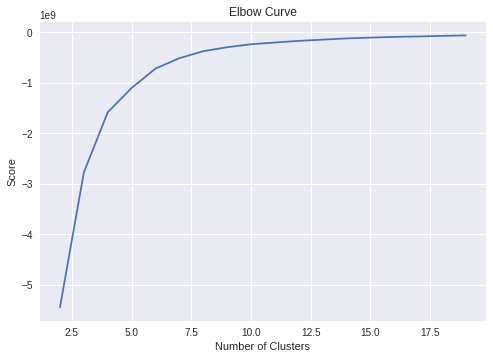

In [746]:
#elbow point
pl.plot(nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

In [0]:
kmeans=KMeans(n_clusters=6)
kmeansoutput=kmeans.fit(z)
#kmeansoutput


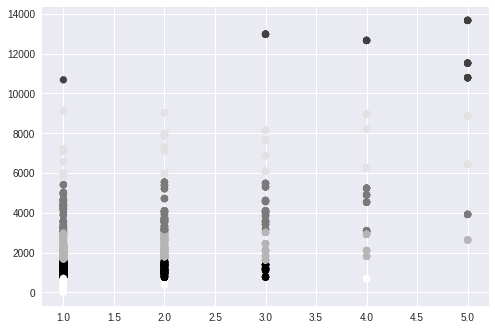

In [748]:

"""pca = PCA(n_components=1).fit(y)
pca_y = pca.transform(y)
pca_x = pca.transform(x)"""

pl.scatter(x[:, 0],y[:, 0], c=kmeansoutput.labels_)
pl.show()

In [749]:
C = kmeans.cluster_centers_
print(C)  
labels = kmeans.labels_

[[1.00611943e+00 3.63867476e+02 3.43342477e+00]
 [2.57575758e+00 7.37532545e+03 3.06060606e+00]
 [1.44874715e+00 2.09791268e+03 3.17995444e+00]
 [2.02693603e+00 3.99711848e+03 3.03703704e+00]
 [4.26923077e+00 1.22597269e+04 3.07692308e+00]
 [1.09733777e+00 1.06799887e+03 3.28826955e+00]]


In [739]:
sample_df.head()

,CustomerID,Recency_val,freq_val,Amount,Mont_val
0,17850.0,1,3,789.47,4
1,13047.0,1,1,1080.48,5
2,13047.0,2,1,1080.48,5
3,13047.0,3,1,1080.48,5
4,13047.0,4,1,1080.48,5


In [0]:
#fetching customers

mailList1_df = sample_df
mailList1_df = mailList1_df[ ((mailList1_df.freq_val ==5)) | ((mailList1_df.freq_val ==4)) | ((mailList1_df.freq_val !=5 & mailList1_df.Amount > 8000.0)) ]

In [775]:
z

array([[3.00000e+00, 7.89470e+02, 1.00000e+00],
       [1.00000e+00, 1.08048e+03, 1.00000e+00],
       [1.00000e+00, 1.08048e+03, 2.00000e+00],
       ...,
       [1.00000e+00, 1.92300e+02, 5.00000e+00],
       [1.00000e+00, 3.60000e+02, 5.00000e+00],
       [1.00000e+00, 2.24890e+02, 5.00000e+00]])

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
color=["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059","#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80","#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100","#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F","#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09","#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66","#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00","#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700","#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329","#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C","#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800","#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51","#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58","#000000"]


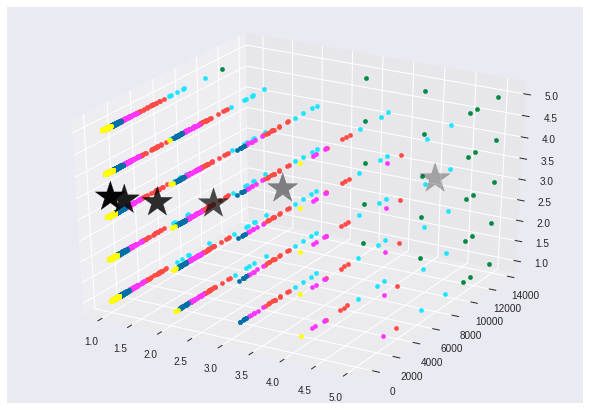

In [778]:

fig = plt.figure()
ax = Axes3D(fig)
for i in range(len(z)):
  ax.scatter(z[i][0], z[i][1],z[i][2],c=color[labels[i]])
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='#050505', s=1000)
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('Monetary Amount')

for angle in range(0, 360):
    ax.view_init(45,angle)
    plt.draw()
    plt.pause(.1)
plt.close()

